In [1]:
### PACKAGES

import pandas as pd
import numpy as np 
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
### DATAFRAME

chunks = pd.read_csv('data.csv', chunksize=2000)
dfs = [] 
for chunk in chunks: # filter dataframe
    df_grav = pd.DataFrame(chunk)
    df_grav_1 = df_grav.loc[:, ['year','country_id_o', 'country_id_d', 'country_exists_o', 'country_exists_d', 'distw_harmonic', 'gdp_ppp_pwt_o', 'gdp_ppp_pwt_d', 'tradeflow_baci', 'comlang_ethno', 'heg_o', 'heg_d', 'sibling_ever', 'contig']]  # selection of relevant variables
    df_grav_2 = df_grav_1[(df_grav_1['country_exists_o'] != 0) & (df_grav_1['country_exists_d'] != 0)]  # keep only observations where both countries existed
    df_grav_3 = df_grav_2.dropna(axis=0, how='any') # drop na
    df_grav_4 = df_grav_3[(df_grav_3['year'] >= 1997)] # filter for years
    dfs.append(df_grav_4)
df = pd.concat(dfs)
df[['gdp_o_log', 'gdp_d_log', 'dist_log', 'tf_log']] = np.log(df[['gdp_ppp_pwt_o', 'gdp_ppp_pwt_d', 'distw_harmonic', 'tradeflow_baci']]) # add logged values

print(df.head(5)) 

     year country_id_o country_id_d  country_exists_o  country_exists_d  \
207  2007          ABW          AGO                 1                 1   
209  2009          ABW          AGO                 1                 1   
210  2010          ABW          AGO                 1                 1   
211  2011          ABW          AGO                 1                 1   
212  2012          ABW          AGO                 1                 1   

     distw_harmonic  gdp_ppp_pwt_o  gdp_ppp_pwt_d  tradeflow_baci  \
207          9579.0     4531907.00     92073624.0           4.044   
209          9579.0     4403982.50     89814960.0           0.501   
210          9574.0     3957929.00    126388792.0       50257.141   
211          9574.0     3813092.50    165386624.0           0.142   
212          9574.0     3773461.75    173114960.0           0.329   

     comlang_ethno  heg_o  heg_d  sibling_ever  contig  gdp_o_log  gdp_d_log  \
207            0.0    0.0    0.0           0.0     0.0

In [3]:
### CORRELATION MATRIX

df[['tf_log','gdp_o_log', 'gdp_d_log', 'dist_log']].corr()

,tf_log,gdp_o_log,gdp_d_log,dist_log
tf_log,1.000000,0.555747,0.384190,-0.220204
gdp_o_log,0.555747,1.000000,-0.130988,0.062499
gdp_d_log,0.384190,-0.130988,1.000000,0.054950
dist_log,-0.220204,0.062499,0.054950,1.000000


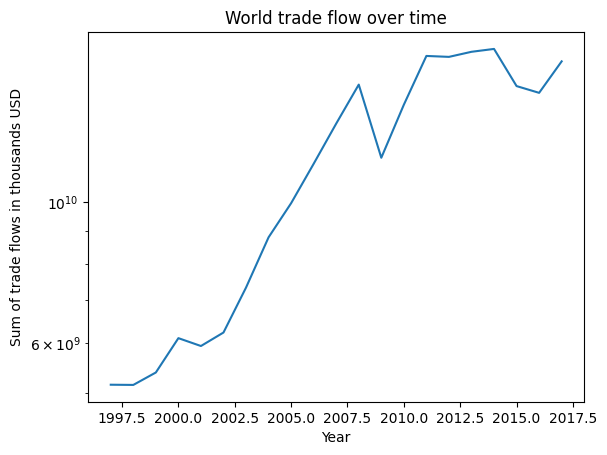

In [4]:
### TRADEFLOW CHART

df_tf = df[['year','country_id_o', 'country_id_d', 'tradeflow_baci']]
df_tf = df_tf.groupby('year')['tradeflow_baci'].sum().reset_index() # sum tradeflows per year

plt.plot(df_tf['year'], df_tf['tradeflow_baci']) 
plt.xlabel('Year')
plt.ylabel('Sum of trade flows in thousands USD')
plt.yscale('log') # log scale
plt.title('World trade flow over time')
plt.show()

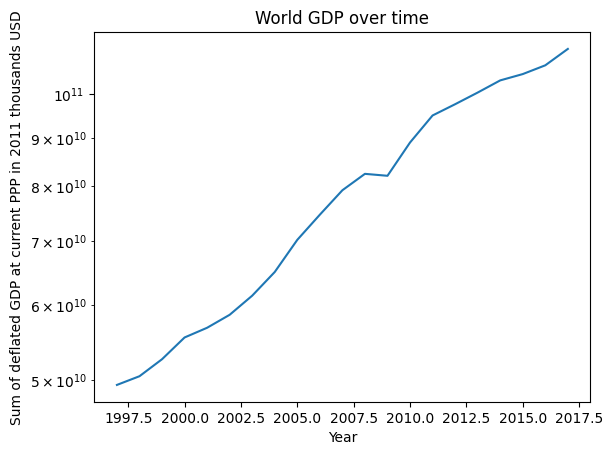

In [5]:
### GDP CHART

df_gdp = df[['year','country_id_o','gdp_ppp_pwt_o']].drop_duplicates() # only select one observations per country per year as GDP is the same
df_gdp = df_gdp.groupby('year')['gdp_ppp_pwt_o'].sum().reset_index() # sum GDP's per year

plt.plot(df_gdp['year'], df_gdp['gdp_ppp_pwt_o']) 
plt.xlabel('Year')
plt.ylabel('Sum of deflated GDP at current PPP in 2011 thousands USD')
plt.yscale('log') # log scale
plt.title('World GDP over time')
plt.show()

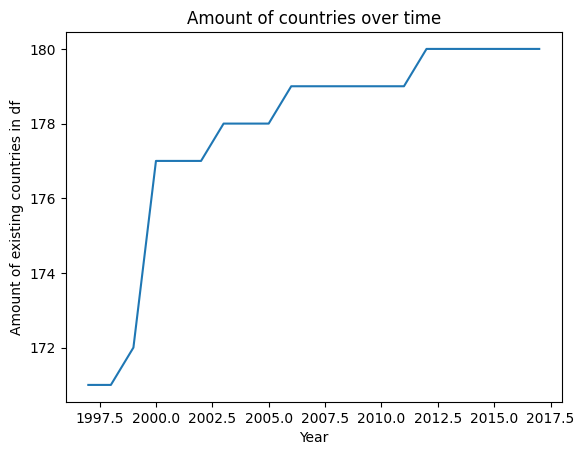

In [6]:
### COUNTRIES CHART 

df_ac = df[['year','country_id_o','country_exists_o']].drop_duplicates() # only select one observations per country per year as the dummy is the same
df_ac = df_ac.groupby('year')['country_exists_o'].sum().reset_index() # amount of countries per year

plt.plot(df_ac['year'], df_ac['country_exists_o'])
plt.xlabel('Year')
plt.ylabel('Amount of existing countries in df')
plt.title('Amount of countries over time')
plt.show()

In [7]:
### INTUITIVE MODEL ESTIMATION

x1 = df[['gdp_o_log', 'gdp_d_log', 'dist_log', 'comlang_ethno', 'heg_o', 'heg_d', 'sibling_ever', 'contig']] # select exogenous variables
x1 = sm.add_constant(x1) # add intercept
y1 = df['tf_log']  # select endogenous variable

reg1 = sm.OLS(y1, x1).fit(cov_type='cluster', cov_kwds={'groups': df['dist_log']}) # run OLS regression clustering standard errors

print(reg1.summary()) 

                            OLS Regression Results                            
Dep. Variable:                 tf_log   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                 1.269e+04
Date:                Thu, 26 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:18:07   Log-Likelihood:            -1.1290e+06
No. Observations:              476945   AIC:                         2.258e+06
Df Residuals:                  476936   BIC:                         2.258e+06
Df Model:                           8                                         
Covariance Type:              cluster                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -21.9014      0.226    -96.860

In [8]:
### THEORETICAL MODEL FIXED EFFECTS ESTIMATION

dummies = pd.get_dummies(df[['country_id_o', 'country_id_d']], prefix=['o','d']) # create fixed effects dummies
dummies = dummies.loc[:, dummies.columns != 'o_USA'] # remove one to avoid multicollinearity
dummies = dummies.loc[:, dummies.columns != 'd_USA']
dummies = dummies.astype(int)

x2 = df[['gdp_o_log', 'gdp_d_log', 'dist_log', 'comlang_ethno', 'heg_o', 'heg_d', 'sibling_ever', 'contig']]  # select exogenous variables
x2 = pd.concat([x2, dummies], axis=1)  # add fixed effects
x2 = sm.add_constant(x2) # add intercept
y2 = df['tf_log'] # select endogenous variable

reg2 = sm.OLS(y2, x2).fit(cov_type='cluster', cov_kwds={'groups': df['dist_log']}) # run OLS regression clustering standard errors

print(reg2.summary().tables[0]) 
print(pd.DataFrame({'Parameters': reg2.params,'Standard Errors': reg2.bse,'P-Values': reg2.pvalues}).head(13))

                            OLS Regression Results                            
Dep. Variable:                 tf_log   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     747.5
Date:                Thu, 26 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:18:36   Log-Likelihood:            -1.0390e+06
No. Observations:              476945   AIC:                         2.079e+06
Df Residuals:                  476576   BIC:                         2.083e+06
Df Model:                         368                                         
Covariance Type:              cluster                                         
               Parameters  Standard Errors       P-Values
const           -6.192985         0.464902   1.746140e-40
gdp_o_log        0.757632         0.021198  8.947333e-280
gdp_d_log        0.906816         0.